## Generate Result Tables
- MCHAD
- CAC
- II
- Center Loss
- G-MCHAD
- G-Center
- G-CAC

In [87]:
import seaborn as sb
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import pandas as pd
from os.path import join

In [88]:
sb.set()
sb.set_style("whitegrid")
sb.set_context("paper")

In [89]:
# root folder for experiment run
root = "/run/media/ki/INTENSO/tmp/newmchad/22-17-59-05/"

In [90]:
# map test cases
dataset_map = {
    "test_vs_uniformnoise": "Uniform",
    "test_vs_gaussiannoise": "Gaussian",
    "test_vs_tinycrop": "Tiny Crop",
    "test_vs_tinyresize": "Tiny Resize",
    "test_vs_lsuncrop": "LSUN Crop",
    "test_vs_lsunresize": "LSUN Resize",
    "test_vs_textures": "Texture",
}

model_map = {
    "src.models.CAC": "CAC",
    "src.models.Softmax": "Softmax",
    "src.models.MCHAD": "MCHAD",
    "src.models.Center": "Center",
    "src.models.II": "II",
    "src.models.GCAC": "G-CAC",
    "src.models.GCenter": "G-Center",
}


train_dataset_map = {
    "src.datamodules.CIFAR10DataModule": "CIFAR10",
    "src.datamodules.SVHNDataModule": "SVHN",
    "src.datamodules.CIFAR100DataModule": "CIFAR100",
}

In [91]:
def convert(df, key="Distance", task="OOD"):
    """
    Get correct metrics from dataframe
    """
    df.rename(
        inplace=True,
        columns={
            "Accuracy/test": "Accuracy",
            f"{key}/{task}/AUROC/test": "AUROC",
            f"{key}/{task}/AUPR-IN/test": "AUPR-IN",
            f"{key}/{task}/AUPR-OUT/test": "AUPR-OUT",
            f"{key}/{task}/FPR95TPR/test": "FPR95",
        },
    )

    return df

In [92]:
directories = []
directories += [f"./svhn/center/{i}" for i in range(21)]
directories += [f"./svhn/mchad/{i}" for i in range(21)]
directories += [f"./svhn/gmchad/{i}" for i in range(21)]
# directories += [f"./svhn/gcenter/{i}" for i in range(21)]
# directories += [f"./svhn/gcac/{i}" for i in range(21)]
directories += [f"./svhn/cac/{i}" for i in range(21)]
directories += [f"./svhn/ii/{i}" for i in range(21)]

directories += [f"./cifar100/mchad/{i}" for i in range(21)]
# directories += [f"./cifar100/gmchad/{i}" for i in range(21)]
# directories += [f"./cifar100/gcenter/{i}" for i in range(21)]
# directories += [f"./cifar100/gcac/{i}" for i in range(21)]
directories += [f"./cifar100/cac/{i}" for i in range(21)]
directories += [f"./cifar100/ii/{i}" for i in range(21)]
directories += [f"./cifar100/center/{i}" for i in range(21)]


# del directories[directories.index("./cifar100/cac/13")]
directories += [f"./cifar10/mchad/{i}" for i in range(21)]
directories += [f"./cifar10/center/{i}" for i in range(21)]
directories += [f"./cifar10/gmchad/{i}" for i in range(21)]
directories += [f"./cifar10/gcenter/{i}" for i in range(21)]
directories += [f"./cifar10/gcac/{i}" for i in range(21)]
directories += [f"./cifar10/cac/{i}" for i in range(21)]
directories += [f"./cifar10/ii/{i}" for i in range(21)]

In [93]:


def get_training_set(datamodule):
    target = datamodule["_target_"]
    d = train_dataset_map.get(target)

    if not d:
        if target == "src.datamodules.MultiDatamodule":
            d = train_dataset_map.get(datamodule["module1"]["_target_"])

    if not d:
        print(datamodule)
    else:
        print(d)

    return d


def load(path):
    local_df = []

    df = pd.read_csv(join(path, "results.csv"))
    metrics = pd.read_csv(join(path, "csv/version_0/metrics.csv"))
    config = OmegaConf.load(join(path, "tb/version_0/hparams.yaml"))
    df["Dataset"] = get_training_set(config["datamodule"])
    df["Outliers"] = df["test_case_name"].apply(dataset_map.get)
    model = str(config["model"]["_target_"])

    if model == "src.models.CAC":
        df["Model"] = "CAC"
        df = convert(df, "Distance")
    elif model == "src.models.SoftMax":
        print("EB-OOD")
        df_ebm = df.copy(deep=True)
        df_ebm["Model"] = "EB-OOD"
        df_emb = convert(df_ebm, "EnergyBased")

        local_df.append(df_ebm)

        print("Softmax")
        df["Model"] = "Softmax"
        df = convert(df, "Softmax")

    elif model == "src.models.MCHAD":
        if config["model"]["weight_oe"] == 0.0:
            # print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "MCHAD"
        else:
            print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "G-MCHAD"

        df = convert(df)
    elif model == "src.models.Center":
        df["Model"] = "Center"
        df = convert(df, "Softmax")
    elif model == "src.models.IIModel":
        df["Model"] = "II"
        df = convert(df)
    elif model == "src.models.GCenter":
        df["Model"] = "G-Center"
        df = convert(df, key="Softmax")
    elif model == "src.models.GCAC":
        df["Model"] = "G-CAC"
        df = convert(df, key="Distance")
    else:
        raise Exception(f"UNKNOWN: {model}")

    local_df.append(df)
    return config, pd.concat(local_df), metrics

In [94]:
dfs = []

for d in directories:
    # filter(lambda x: "center" not in x and "cifar100/softmax/" not in x and "mchad-o" not in x, directories):
    path = join(root, d)
    config, df, metrics = load(path)
    try:
        if df is not None:
            print(path)
            print(
                f"{df['Dataset'][0]}/{df['Model'][0]} -> {df['AUROC'].mean()} {len(df)}"
            )
            df = df[
                [
                    "Accuracy",
                    "AUROC",
                    "AUPR-IN",
                    "AUPR-OUT",
                    "FPR95",
                    "Dataset",
                    "Outliers",
                    "Model",
                ]
            ]
            dfs.append(df.copy())
    except Exception as e:
        print("EXCEPTION WHILE LOADING")
        print(type(e), e)
        print(df.columns)

df = pd.concat(dfs)

SVHN
/run/media/ki/INTENSO/tmp/newmchad/22-17-59-05/./svhn/center/0
SVHN/Center -> 0.9788148828915187 8
SVHN
/run/media/ki/INTENSO/tmp/newmchad/22-17-59-05/./svhn/center/1
SVHN/Center -> 0.9838987588882446 8
SVHN
/run/media/ki/INTENSO/tmp/newmchad/22-17-59-05/./svhn/center/2
SVHN/Center -> 0.9768552354403904 8
SVHN
/run/media/ki/INTENSO/tmp/newmchad/22-17-59-05/./svhn/center/3
SVHN/Center -> 0.9694117307662964 8
SVHN
/run/media/ki/INTENSO/tmp/newmchad/22-17-59-05/./svhn/center/4
SVHN/Center -> 0.9740219712257385 8
SVHN
/run/media/ki/INTENSO/tmp/newmchad/22-17-59-05/./svhn/center/5
SVHN/Center -> 0.9783951214381627 8
SVHN
/run/media/ki/INTENSO/tmp/newmchad/22-17-59-05/./svhn/center/6
SVHN/Center -> 0.9779999937329974 8
SVHN
/run/media/ki/INTENSO/tmp/newmchad/22-17-59-05/./svhn/center/7
SVHN/Center -> 0.9729101146970477 8
SVHN
/run/media/ki/INTENSO/tmp/newmchad/22-17-59-05/./svhn/center/8
SVHN/Center -> 0.973568320274353 8
SVHN
/run/media/ki/INTENSO/tmp/newmchad/22-17-59-05/./svhn/center

In [95]:
df["AUROC"] = df["AUROC"].apply(lambda x: x * 100)
df["AUPR-IN"] = df["AUPR-IN"].apply(lambda x: x * 100)
df["AUPR-OUT"] = df["AUPR-OUT"].apply(lambda x: x * 100)
df["FPR95"] = df["FPR95"].apply(lambda x: x * 100)
df["Accuracy"] = df["Accuracy"].apply(lambda x: x * 100)

In [96]:
# , "Tiny Crop", "LSUN Crop"
df = df[df["Outliers"].isin(["Texture", "Tiny Resize", "LSUN Resize", "Uniform", "Gaussian"])]
df = df.set_index(["Dataset", "Outliers", "Model"]).dropna()


In [97]:
from itertools import product
datasets = ["SVHN", "CIFAR10", "CIFAR100"]
# models = ["CAC", "II", "Center", "Softmax", "EB-OOD", "MCHAD", "G-MCHAD"]
models = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]

t =  df.reset_index().groupby(by=["Dataset", "Model"]).agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    ).reindex(list(product(datasets, models)))

s = t.to_latex(
        float_format="%.2f",
        multirow=True,
        escape=False,
        label="tab:results",
        # bold_rows="True",
    )

repl = {
    "mean": "Mean",
    "sem": "$\\pm \sigma_{\\bar{x}}$",
    " MCHAD": " \\textbf{MCHAD (ours)}",
    "G-MCHAD": "\\textbf{G-MCHAD (ours)}",
    "G-Center": "\\textbf{G-Center (ours)}",
    "G-CAC": "\\textbf{G-CAC (ours)}",
}

for k, v in repl.items():
    s = s.replace(k, v)

print(s)

\begin{table}
\centering
\label{tab:results}
\begin{tabular}{llrrrrrrrrrr}
\toprule
         &       & \multicolumn{2}{l}{Accuracy} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95} \\
         &       &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ &    Mean &  $\pm \sigma_{\bar{x}}$ &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ \\
Dataset & Model &          &      &       &      &         &      &          &      &       &      \\
\midrule
\multirow{7}{*}{SVHN} & \textbf{MCHAD (ours)} &    94.43 & 0.02 & 98.90 & 0.08 &   96.14 & 0.28 &    99.65 & 0.03 &  4.50 & 0.34 \\
         & II &    12.17 & 0.22 & 51.28 & 2.00 &   31.33 & 1.80 &    76.08 & 1.19 & 82.36 & 2.57 \\
         & CAC &    94.22 & 0.04 & 93.25 & 0.39 &   81.93 & 0.81 &    96.51 & 0.25 & 33.38 & 2.38 \\
         & Center &    94.83 & 0.02 & 97.72 & 0.15 &   93.04 & 0.49 &    99.20 & 0.05 &  8.45 & 0.53 \\
  

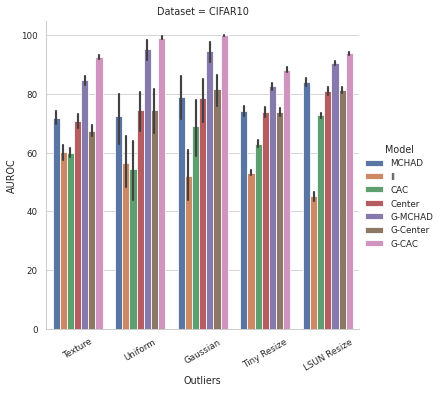

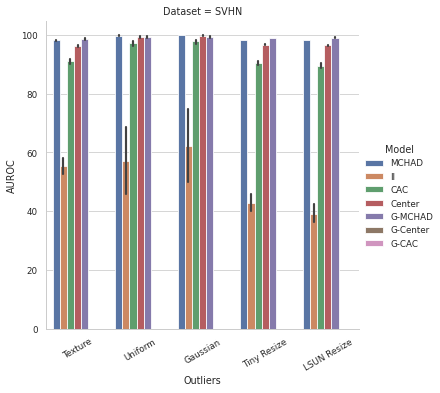

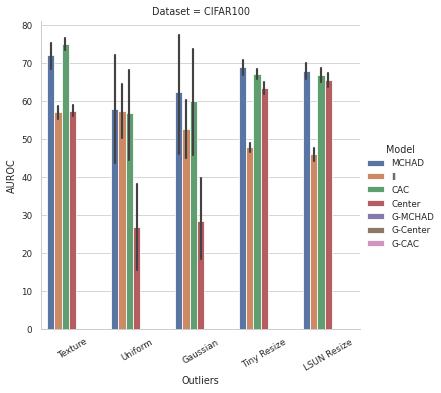

In [98]:
methods = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]
# ,
for dataset in ["CIFAR10", "SVHN", "CIFAR100"]:
    g = sb.catplot(
        data=df.reset_index()[df.reset_index()["Dataset"] == dataset],
        x="Outliers",
        y="AUROC",
        kind="bar",
        hue="Model",
        col="Dataset",
        hue_order=methods
    )
    g.set_xticklabels(rotation=30)
    plt.savefig(f"out/single-auroc-{dataset}.png", dpi=300)
    plt.show()

In [99]:
tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")| (tmp["Model"] == "G-CAC") | (tmp["Model"] == "G-Center")]

print(
    tmp
    .groupby(by=["Dataset", "Model"])
    .agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    )
    .to_html(
        float_format="%.2f",
        escape=False,
    )
)


<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="2" halign="left">Accuracy</th>
      <th colspan="2" halign="left">AUROC</th>
      <th colspan="2" halign="left">AUPR-IN</th>
      <th colspan="2" halign="left">AUPR-OUT</th>
      <th colspan="2" halign="left">FPR95</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
    </tr>
    <tr>
      <th>Dataset</th>
      <th>Model</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="7" valign="top">CIFAR10</th>
      <th>CAC</th>
      <td>88.83</td>
      <td>0.04</td>
      <td>63.76</td>
      <td>1.57</td>
      <td>6

In [100]:
tmp.groupby(by=["Dataset", "Model"]).agg(
    {
        "Accuracy": ["mean", "sem"],
        "AUROC": ["mean", "sem"],
        "AUPR-IN": ["mean", "sem"],
        "AUPR-OUT": ["mean", "sem"],
        "FPR95": ["mean", "sem"],
    }
)

Accuracy                AUROC              AUPR-IN  \
                        mean       sem       mean       sem       mean   
Dataset  Model                                                           
CIFAR10  CAC       88.831905  0.036524  63.762821  1.574081  60.977169   
         Center    88.356191  0.026956  75.738388  1.147212  67.840948   
         G-CAC     87.247143  0.056723  94.726544  0.447338  93.655714   
         G-Center  88.281428  0.021940  75.776482  1.114955  68.287362   
         G-MCHAD   88.866190  0.043368  89.531551  0.752683  87.044558   
         II        30.691429  0.120678  53.389117  1.397339  52.059119   
         MCHAD     88.839524  0.036617  76.266955  1.277240  69.838944   
CIFAR100 CAC       67.300953  0.103599  65.142868  1.975410  62.564333   
         Center    69.757619  0.024502  48.292989  2.350831  49.097433   
         II         6.790952  0.059669  52.138999  1.238594  47.877129   
         MCHAD     68.630476  0.037722  65.812865  2.143836  61.376238   
SVHN     CAC       94.216642  0.035624  93.247713  0.387315  81.931203   
         Center    94.825416  0.017126  97.716359  0.151933  93.040331   
         G-MCHAD   93.790061  0.033963  99.087546  0.055962  95.424287   
         II        12.170552  0.223809  51.275810  2.004299  31.331168   
         MCHAD     94.431762  0.015323  98.898408  0.079557  96.144517   

                              AUPR-OUT                FPR95            
                        sem       mean       sem       mean       sem  
Dataset  Model                                                         
CIFAR10  CAC       1.389322  66.261280  1.329044  81.032000  2.172674  
         Center    1.244925  82.114212  0.829033  52.480095  1.938763  
         G-CAC     0.531327  94.893122  0.484039  20.660000  1.841760  
         G-Center  1.343260  81.115297  0.864480  55.614667  2.196737  
         G-MCHAD   1.006742  88.895078  0.817385  37.113238  2.518089  
         II        1.045171  57.637109  1.302710  88.810667  1.316223  
         MCHAD     1.300260  80.342512  1.059229  59.016667  2.318411  
CIFAR100 CAC       1.535412  72.537444  1.482336  67.352095  2.063094  
         Center    1.303820  59.277069  1.546671  84.554476  1.287216  
         II        0.805828  58.295200  1.316167  86.221714  1.625653  
         MCHAD     1.598417  74.212212  1.543876  64.071143  2.296533  
SVHN     CAC       0.806741  96.506972  0.250649  33.376467  2.383416  
         Center    0.486451  99.199582  0.053339   8.445064  0.533365  
         G-MCHAD   0.324213  99.732086  0.015994   2.913740  0.201698  
         II        1.802622  76.080428  1.185717  82.364855  2.568314  
         MCHAD     0.276297  99.647457  0.026221   4.496188  0.337126

In [101]:
from scipy.stats import ttest_ind

tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")]

for metric in ["Accuracy", "AUROC", "AUPR-IN", "AUPR-OUT", "FPR95"]:
    for dataset in ["SVHN", "CIFAR10", "CIFAR100"]:
        a = tmp[(tmp["Model"] == "CAC") & (tmp["Dataset"] == dataset)][metric]
        b = tmp[(tmp["Model"] == "MCHAD") & (tmp["Dataset"]== dataset)][metric]
        stat, p = ttest_ind(a,b, equal_var=False)
        print(f"{metric} {dataset} -> {p < 0.05} ")

Accuracy SVHN -> True 
Accuracy CIFAR10 -> False 
Accuracy CIFAR100 -> True 
AUROC SVHN -> True 
AUROC CIFAR10 -> True 
AUROC CIFAR100 -> False 
AUPR-IN SVHN -> True 
AUPR-IN CIFAR10 -> True 
AUPR-IN CIFAR100 -> False 
AUPR-OUT SVHN -> True 
AUPR-OUT CIFAR10 -> True 
AUPR-OUT CIFAR100 -> False 
FPR95 SVHN -> True 
FPR95 CIFAR10 -> True 
FPR95 CIFAR100 -> False 
